In [1]:
import streaky_players
import wald_wolfowitz
import streak_converter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [3]:
from qbstyles import mpl_style

mpl_style(dark=True)

## LeMartingale
I got the question of why it's OK to use a player's overall FG% to gauge their streakiness. We know that every shot a player takes has a slightly different level of difficulty, and thus a different probability that it will go in. Shouldn't that affect the streakiness?

It's a good question.  Let's say you've got a bag with 2 coins inside. One of them comes up heads 40% of the time, the other comes up heads 60% of the time. You can't tell which is which. If you select a coin randomly out of the bag and flip it, what are the chances it comes up heads? It's 50%, right? The selecting of the coin and the flipping of the coin are two independent steps. We can multiply the probabilities at each step together, so the chances of heads are `(.5 * .4) + (.5 * .6) = .5`

So, it's fine to use the overall FG% as long as there's no memory to the process -- the previous shot selections and results have no bearing on the chances of the next shot going in. In mathematics, this is known as a [martingale](https://en.wikipedia.org/wiki/Martingale_(probability_theory)).

If I create a simulation of LeBron James that uses his exact shooting tendencies and FG percentages, and the shot selection is totally random, it shouldn't show any streaky or unstreaky tendencies beyond expected by chance. Let's see what LeSimulation looks like.

Loading data from previous notebook...

In [4]:
aug = pd.read_feather("streak-augment.feather")

In [5]:
lebron_shots = aug[aug.PLAYER_ID == 2544].copy()

In [6]:
lebron_shots.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,SORTABLE_DATE,makes_in_game,misses_in_game,shot_seq,shoot_pct,last_5
585,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,10-29-2003,20300014,...,15,1,8,56,2003-10-29,0,0,1,0.00,NaN
636,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,10-29-2003,20300014,...,13,1,7,44,2003-10-29,1,0,2,1.00,NaN
671,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,10-29-2003,20300014,...,16,1,7,1,2003-10-29,2,0,3,1.00,NaN
696,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,10-29-2003,20300014,...,14,1,6,29,2003-10-29,3,0,4,1.00,NaN
762,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,10-29-2003,20300014,...,5,1,4,48,2003-10-29,3,1,5,0.75,NaN


his fg% for each shot type.

In [7]:
lebron_fg_pct_zones = lebron_shots.groupby(["BASIC_ZONE"])["SHOT_MADE"].value_counts() / lebron_shots.groupby(["BASIC_ZONE"])["BASIC_ZONE"].value_counts()

lebron_fg_pct_zones[:,True]

BASIC_ZONE
Above the Break 3        0.344598
Backcourt                0.058824
In The Paint (Non-RA)    0.401369
Left Corner 3            0.394799
Mid-Range                0.379890
Restricted Area          0.720138
Right Corner 3           0.370370
Name: count, dtype: float64

how often he takes each type of shot

In [8]:
lebron_frequency_zones = lebron_shots.groupby(["BASIC_ZONE"])["BASIC_ZONE"].value_counts() / len(lebron_shots)

In [9]:
lebron_frequency_zones

BASIC_ZONE
Above the Break 3        0.204940
Backcourt                0.001160
In The Paint (Non-RA)    0.109652
Left Corner 3            0.014431
Mid-Range                0.267715
Restricted Area          0.386442
Right Corner 3           0.015660
Name: count, dtype: float64

In [10]:
le_shooting_weights = lebron_frequency_zones.values

In [11]:
le_shooting_percentages = lebron_fg_pct_zones[:,True].values

the probabilities need to add to 1, and they do

In [12]:
sum(le_shooting_weights)

np.float64(1.0)

In [13]:
## TODO: copy-pasted from a previous notebook with minor modifications... should clean this up

def sim_career(sim_player, shots_per_game):
    makes_misses = []
    for shot_count in shots_per_game:
        for x in range(shot_count):
            makes_misses.append(sim_player.take_shot())
        sim_player.end_game()
    return pd.Series(makes_misses)

def handle_season(results):
    makes = sum(results > 0)
    misses = sum(results == 0)
    if (makes + misses) > 3:
        expected = wald_wolfowitz.get_expected_streaks(makes, misses)
        streak_data = streak_converter.convert_to_streaks(results)
        total_streaks = streak_data['total_streaks']
        variance = wald_wolfowitz.get_variance(makes, misses, expected)
        if variance > 0:
            z_score = (total_streaks - expected) / np.sqrt(variance)
            return (total_streaks, expected, variance, z_score)
        else:
            return None
    else:
        return None # not enough data!

def sim_multiple(num_seasons, sim_player, shots_per_game):
    seasons_result = []
    for x in range(num_seasons):
        results = sim_career(sim_player, shots_per_game)
        stat_results = handle_season(results)
        seasons_result.append(stat_results)

    return seasons_result

I need a list of number of shots attempted by LeBron in each game. it's not relevant for this sim, but will be useful to model unstreakiness thru shot selection later on.

In [14]:
lebron_shots_by_game = lebron_shots.groupby("GAME_ID")["GAME_ID"].value_counts().values

In [15]:
le_simulation = streaky_players.VariableFGPlayer(le_shooting_weights, 
                                                le_shooting_percentages)

I am going to simulate LeBron's entire career 1,000 times and plot the z-scores for number of streaks. there's no reason why we should see any streaky or unstreaky tendency because shot selection and FG% are independent.

In [16]:
le_results = sim_multiple(1000, le_simulation, lebron_shots_by_game)

In [17]:
def summary_plot(sim, min_z=-4, max_z=4):
    sim_summary = pd.DataFrame(sim, columns=["actual", "expected", "variance", "z_score"])
    sim_summary.z_score.hist(bins=np.arange(min_z, max_z, .5), density=True)
    x = np.linspace(min_z,max_z,200)
    plt.plot(x, scipy.stats.norm.pdf(x, 0, 1))
    return sim_summary


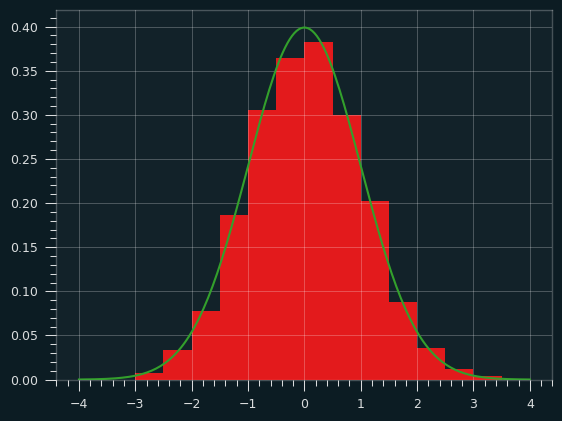

In [18]:
le_fake_career = summary_plot(le_results)

mean isn't equal to zero, but close enough

In [19]:
le_fake_career.z_score.describe()

count    1000.000000
mean        0.032042
std         1.005575
min        -2.844850
25%        -0.648546
50%         0.038302
75%         0.684430
max         3.302983
Name: z_score, dtype: float64

<Axes: >

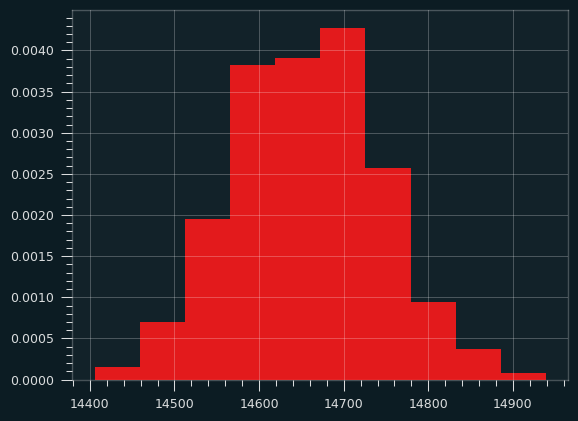

In [20]:
le_fake_career.actual.hist(density=True)

In [21]:
lebron_shots

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,SORTABLE_DATE,makes_in_game,misses_in_game,shot_seq,shoot_pct,last_5
585,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,10-29-2003,20300014,...,15,1,8,56,2003-10-29,0,0,1,0.000000,NaN
636,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,10-29-2003,20300014,...,13,1,7,44,2003-10-29,1,0,2,1.000000,NaN
671,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,10-29-2003,20300014,...,16,1,7,1,2003-10-29,2,0,3,1.000000,NaN
696,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,10-29-2003,20300014,...,14,1,6,29,2003-10-29,3,0,4,1.000000,NaN
762,2004,2003-04,1610612739,Cleveland Cavaliers,2544,LeBron James,G,SG,10-29-2003,20300014,...,5,1,4,48,2003-10-29,3,1,5,0.750000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230836,2024,2023-24,1610612747,Los Angeles Lakers,2544,LeBron James,F,PF,04-14-2024,22301195,...,24,4,7,10,2024-04-14,8,7,16,0.533333,0.6
4230842,2024,2023-24,1610612747,Los Angeles Lakers,2544,LeBron James,F,PF,04-14-2024,22301195,...,2,4,7,5,2024-04-14,8,8,17,0.500000,0.4
4230940,2024,2023-24,1610612747,Los Angeles Lakers,2544,LeBron James,F,PF,04-14-2024,22301195,...,1,4,5,18,2024-04-14,9,8,18,0.529412,0.6
4231011,2024,2023-24,1610612747,Los Angeles Lakers,2544,LeBron James,F,PF,04-14-2024,22301195,...,19,4,3,54,2024-04-14,10,8,19,0.555556,0.6


## LeSimulation 2

Now I'm going to model what we saw in the last notebook, that Lebron's shooting percentage changes based on how many of his last five he's made.

In [22]:
# I just cut and pasted from the previous notebook...
base_rate = .506192 # overall fg%

last5 =  { # fg% based on number of makes in last 5 shots
             0: .564612,
             1: .507120,
             2: .505937,
             3: .496538,
             4: .473849,
             5: .464052
        }

le_simulation2 = streaky_players.LastFivePlayer(last5, base_rate)

I'll do 1,000 sims again, with this new version.

In [23]:
le_results2 = sim_multiple(1000, le_simulation2, lebron_shots_by_game)


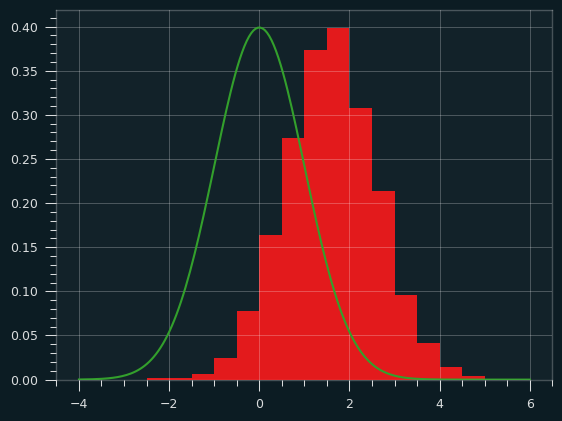

In [24]:
le_fake_career2 = summary_plot(le_results2, -4, 6)

So, it's pretty un-streaky. But ot's still not that close to the real thing. The max z_score in 1000 simulations is only 4.5, which doesn't come close to LeBron's actual 5.9 score.

In [25]:
le_fake_career2.z_score.describe()

count    1000.000000
mean        1.596743
std         0.999813
min        -2.089457
25%         0.915988
50%         1.597707
75%         2.249241
max         4.893245
Name: z_score, dtype: float64

## LeSimulation3

While I'm messing around, what about a fake player where the streaks don't reset between games? That should make the fake player even more unstreaky.

As a fast test, I will just knock out the `end_game` function that would normally reset the shooting history. After the 5th shot of his career, every shot will be influenced by the previous 5 shots, even if they happened in the previous game.

In [26]:
le_simulation3 = streaky_players.LastFivePlayer(last5, base_rate)

def le_no_op(*args):
    pass

#LeMonkeyPatch
le_simulation3.end_game = le_no_op

In [27]:
le_results3 = sim_multiple(1000, le_simulation3, lebron_shots_by_game)

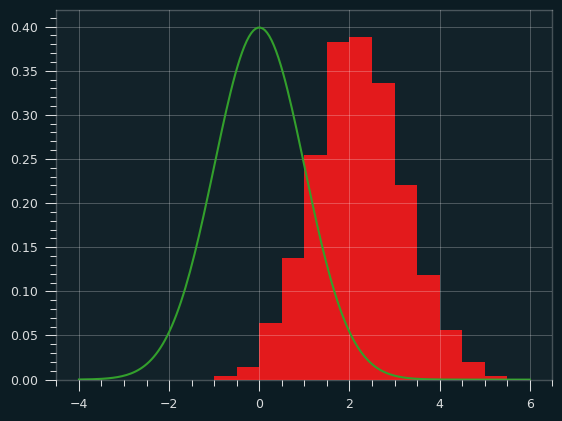

In [28]:
le_fake_career3 = summary_plot(le_results3, -4, 6)

yeah, so the mean went from 1.6 to 2.2, and the max z score went from 4.5 to 5.1. That's still not nearly unstreaky enough to match LeReal LeBron.

In [29]:
le_fake_career3.z_score.describe()

count    1000.000000
mean        2.214100
std         0.987818
min        -0.562358
25%         1.549498
50%         2.220514
75%         2.861791
max         5.619004
Name: z_score, dtype: float64

it's possible that if we tracked the last 7 shots, or 9, instead of 5, we would see even more of a dramatic change in fg%age. Or there's some other factor I haven't considered that is adding unstreakiness, such as the fact that his fg%age tends to go down the more shots he's taken in a game.

## Do other players have the same pattern as LeBron?

At the end of the last notebook, I found that players with a high Z score tend to have the same trend as LeBron in aggregate. But some high Z scores should be due to chance alone. Can we "fingerprint" the players that behave similar to LeBron?

There is a more sensible way of measuring similarity, which I will get to, but first my crazy thing.

In [ ]:
def get_last_fives(shots):

    number_cols = ['0', '1', '2', '3', '4', '5']
    all_last_fives = pd.DataFrame(columns=number_cols)

    n_failed = 0
    n_success = 0

    for player_id, data in shots.groupby("PLAYER_ID"):
        player_percents = (data.groupby("last_5")["SHOT_MADE"].value_counts() / 
                        data.groupby("last_5")["last_5"].value_counts())

        # I am going to skip players that don't have all 6 values
        # there is probably a less silly way of doing this, but I am tired
        if len(player_percents) == 12:
            all_last_fives.loc[player_id,:] = player_percents[:,True].values
            n_success += 1
        else:
            n_failed += 1

        #all_last_fives[player_id] = player_percents
    return all_last_fives

all_last_fives = get_last_fives(aug)

so we're looking for players where the FG% steadily goes down, but there could be some noise. I can look at players where 4 out of 5 are decreasing. 

then I can look at those players' career z-scores.

In [31]:
all_last_fives['diffs'] = all_last_fives['0'] - all_last_fives['5']

comps = [(all_last_fives['0'] > all_last_fives['1']), 
        (all_last_fives['1'] > all_last_fives['2']), 
        (all_last_fives['2'] > all_last_fives['3']), 
        (all_last_fives['3'] > all_last_fives['4']),
        (all_last_fives['4'] > all_last_fives['5'])]

# at least 4 out of 5 are decreasing
lebron_esque = all_last_fives[(sum(comps) >= 4)]

In [32]:
some_guys = aug[aug.PLAYER_ID.isin(lebron_esque.index)].PLAYER_NAME.unique()
print(len(some_guys))

181


In [33]:
some_guys

array(['Karl Malone', 'Dirk Nowitzki', 'Antawn Jamison',
       'Anfernee Hardaway', 'Brevin Knight', 'Tony Delk', 'Tracy McGrady',
       'Jarvis Hayes', 'Shareef Abdur-Rahim', 'Kenyon Martin',
       'Peja Stojakovic', 'Richard Hamilton', 'Michael Redd',
       'Ben Wallace', 'Erick Dampier', 'Jamaal Magloire', 'Larry Hughes',
       'Stephen Jackson', 'Zach Randolph', 'Bonzi Wells',
       'Latrell Sprewell', 'LeBron James', 'David Wesley',
       'Calbert Cheaney', 'Brendan Haywood', 'Brian Skinner',
       'Carlos Arroyo', 'Jalen Rose', 'Damon Stoudamire',
       'Tayshaun Prince', 'Marcus Banks', 'Raja Bell', 'Ruben Patterson',
       'Juan Dixon', 'Darius Songaila', 'Rashard Lewis', 'Flip Murray',
       'Keyon Dooling', 'Eddie House', 'Jason Kapono', 'Pau Gasol',
       'Jason Williams', 'Keith McLeod', 'Earl Watson', 'Melvin Ely',
       'Jason Hart', 'Caron Butler', 'Dahntay Jones', 'Jerry Stackhouse',
       'Devin Harris', 'Carlos Delfino', 'Grant Hill', 'JR Smith',
       

In [34]:
import season_streaks
all_players = season_streaks.get_all_player_streaks()

I will exclude LeBron himself

In [ ]:
lebronlike_careers = all_players[all_players.player_id.isin(lebron_esque.index) & 
                                 (all_players.player_id != 2544)]

yeah, so the z-scores of the 180 or so "lebronesque" players are definitely higher, even compared to all players with a high volume of makes.

In [36]:
lebronlike_careers.z_score.describe()

count    179.000000
mean       1.004496
std        1.310922
min       -3.013187
25%        0.225977
50%        1.101983
75%        1.859693
max        4.061129
Name: z_score, dtype: float64

In [37]:
all_players.z_score.describe()

count    2103.000000
mean        0.308491
std         1.129632
min        -3.977309
25%        -0.449784
50%         0.340279
75%         1.017736
max         5.897434
Name: z_score, dtype: float64

In [38]:
all_players[all_players.makes > 1000].z_score.describe()

count    609.000000
mean       0.740040
std        1.281727
min       -3.977309
25%       -0.047482
50%        0.682940
75%        1.531438
max        5.897434
Name: z_score, dtype: float64

what about players where all 5 are decreasing?

In [39]:
super_lebron_esque = all_last_fives[sum(comps) ==5]

In [40]:
super_lebron_esque

,0,1,2,3,4,5,diffs
252,0.666667,0.585366,0.508197,0.440678,0.36,0.333333,0.333333
255,0.57971,0.514493,0.504556,0.495763,0.444685,0.440476,0.139234
1112,0.633333,0.538012,0.479893,0.465704,0.425926,0.4,0.233333
2067,0.515625,0.418367,0.400802,0.392202,0.338028,0.333333,0.182292
2072,0.553672,0.457534,0.447556,0.431164,0.385643,0.376812,0.176861
2544,0.564612,0.50712,0.505937,0.496538,0.473849,0.464052,0.10056
2553,0.506667,0.435374,0.4197,0.394015,0.301587,0.266667,0.24
2804,0.47619,0.458647,0.441054,0.423756,0.360996,0.277778,0.198413
200755,0.5,0.448017,0.44494,0.425136,0.415061,0.328767,0.171233
201587,0.47486,0.458839,0.429907,0.429046,0.425963,0.394366,0.080494


In [ ]:
super_lebron_careers = all_players.loc[all_players.player_id.isin(super_lebron_esque.index) & 
                                       (all_players.player_id != 2544)]

In [42]:
super_lebron_careers.z_score.describe()

count    18.000000
mean      1.474963
std       1.118765
min      -0.271301
25%       0.624344
50%       1.468939
75%       2.157934
max       3.706956
Name: z_score, dtype: float64

there are 18 players that match. Except for Dragic, none of them have exceptional z scores, and one even has a negative z-score. In aggregate, they are much more unstreaky than the average player, but they're not the outliers I'm looking for.

In [43]:
super_lebron_careers[["player_id", "player_name", "z_score"]].sort_values("z_score", ascending=False)

,player_id,player_name,z_score
823,201609,Goran Dragic,3.706956
299,2072,Michael Redd,2.989043
1318,1626162,Kelly Oubre Jr.,2.796255
852,201942,DeMar DeRozan,2.696541
1622,1629013,Landry Shamet,2.243446
884,201976,Patrick Beverley,1.901400
1592,1628978,Donte DiVincenzo,1.871023
804,201587,Nicolas Batum,1.614275
425,2553,Jarvis Hayes,1.549498
28,255,Grant Hill,1.388380


note -- this is old ass Karl Malone in his last season (2004-2005) so a small sample size

In [70]:
", ".join(super_lebron_careers.player_name)

'Karl Malone, Grant Hill, Ben Wallace, Eddie House, Michael Redd, Jarvis Hayes, Andres Nocioni, JJ Redick, Nicolas Batum, Goran Dragic, DeMar DeRozan, Patrick Beverley, Marcus Morris Sr., Bradley Beal, Kelly Oubre Jr., Norman Powell, Donte DiVincenzo, Landry Shamet'

In [45]:
super_lebron_careers.set_index("player_id").join(all_last_fives).loc[252]

player_name                                               Karl Malone
makes                                                             193
misses                                                            207
total_streaks                                                     202
raw_data            WWWLWLWLLLLWLLWLWWLWLWLWLLLWWWLWLLWWLWLLLLWLLL...
expected_streaks                                              200.755
variance                                                    99.504524
sd                                                           9.975195
z_score                                                       0.12481
ww_percentile                                               54.966285
0                                                            0.666667
1                                                            0.585366
2                                                            0.508197
3                                                            0.440678
4                   

In [46]:
all_last_fives

,0,1,2,3,4,5,diffs
56,0.446809,0.435897,0.44686,0.466307,0.417178,0.470588,-0.02378
57,0.444444,0.434783,0.507692,0.439716,0.454545,0.166667,0.277778
84,0.506667,0.398119,0.378099,0.423684,0.418301,0.090909,0.415758
109,0.666667,0.37931,0.380952,0.415385,0.210526,0.25,0.416667
120,0.3,0.363636,0.340909,0.410256,0.4,0.666667,-0.366667
...,...,...,...,...,...,...,...
1641722,0.6,0.307692,0.454545,0.347826,0.25,0.333333,0.266667
1641733,0.2,0.4375,0.322581,0.5625,0.2,0.5,-0.3
1641739,0.666667,0.481481,0.346154,0.425,0.333333,0.5,0.166667
1641871,0.5,0.472222,0.530303,0.532258,0.416667,0.666667,-0.166667


## Similarity measures the right way

If you want to compare two discrete probability distributions, there is a metric called K-L divergence, or relative entropy. If the relative entropy is low, the two distributions are similar, and if it is high, they are different.

I want to find players whose fg percentages @ 0..5 makes are as similar as possible to LeBron's.  these shooting percentages aren't a probability distribution -- they don't sum to one. so relative entropy isn't the right metric to use. but it's still a way to compare two discrete functions.

Below are LeBron's FG%ages at 0..5 makes. I could make these probability distribution-like by normalizing -- dividing each one by the sum of all of them. However, scipy's function automatically does this for us, as verified below.

Raw numbers for LeBron:

In [47]:
all_last_fives.loc[2544]

0        0.564612
1         0.50712
2        0.505937
3        0.496538
4        0.473849
5        0.464052
diffs     0.10056
Name: 2544, dtype: object

Normalized:

In [48]:
all_last_fives.loc[2544, number_cols] / sum(all_last_fives.loc[2544, number_cols])

0    0.187448
1     0.16836
2    0.167968
3    0.164847
4    0.157315
5    0.154062
Name: 2544, dtype: object

In [49]:
lebron_normal  = all_last_fives.loc[2544, number_cols] / sum(all_last_fives.loc[2544, number_cols])

I will compare LeBron to player id 57.

In [50]:
otherguy_normal = all_last_fives.loc[57, number_cols] / sum(all_last_fives.loc[57, number_cols])

In [51]:
scipy.stats.entropy(lebron_normal.astype("float").values, otherguy_normal.astype("float").values)

np.float64(0.04709365566037409)

In [52]:
scipy.stats.entropy(all_last_fives.loc[2544, number_cols].astype("float").values,
                    all_last_fives.loc[57, number_cols].astype("float").values,
                    )

np.float64(0.04709365566037392)

ok, this is crappy code...

I will also calculate Wasserstein (earth mover) distance and Jensen-Shannon distance, which may be more appropriate here.

In [53]:
all_last_fives['lbj_entropy'] = None
all_last_fives['lbj_wass'] = None
all_last_fives['lbj_jensen'] = None

lbj_exact_vals = all_last_fives.loc[2544, number_cols].astype("float").values


In [54]:
for player_id, data in all_last_fives.iterrows():
    current_entropy = scipy.stats.entropy(lbj_exact_vals, data[number_cols].astype("float").values)
    all_last_fives.loc[player_id, 'lbj_entropy'] = current_entropy

    
    jensen = scipy.spatial.distance.jensenshannon(lbj_exact_vals,  data[number_cols].astype("float").values)
    all_last_fives.loc[player_id, 'lbj_jensen'] = jensen

    # I don't know why wasserstein distance isn't meaningful, but the results are totally bogus regardless of whether I pre-normalize
    wass = scipy.stats.wasserstein_distance(lbj_exact_vals, data[number_cols].astype("float").values)
    all_last_fives.loc[player_id, 'lbj_wass'] = wass

I'm going to look at the 100 players most like LeBron.

I will join the two data sets together so we can sort

In [55]:
#all_players.set_index("player_id")
players_with_fives = all_players.set_index("player_id").join(all_last_fives)

In [56]:
smallest_entropy = players_with_fives.sort_values("lbj_entropy")[1:101]

Well, that worked! I wasn't totally confident, but the top players all have the LeBron tendency where their FG% goes pretty steadily downward from 0..5 makes in the last 5. CJ McCollum shoots 50.4% when he's missed his last 5, and 41.2% when he's made his last 5. Rozier drops from 47% at 0 makes to 39% at 5 makes. Bargnani drops from 49% to 40%.

As we saw last time, Richard Hamilton had the least streaky game in NBA history, so it's not surprising to see him popping up here.

In [57]:
smallest_entropy[:10]

,player_name,makes,misses,total_streaks,raw_data,expected_streaks,variance,sd,z_score,ww_percentile,0,1,2,3,4,5,diffs,lbj_entropy,lbj_wass,lbj_jensen
player_id,,,,,,,,,,,,,,,,,,,,
203468,CJ McCollum,5427,6539,6003,LWLWLWLLWWWLWLLWLWLLWLLWWLLWLLWWLWWLWLLLWLLWWL...,5932.330938,2939.804042,54.219960,1.303377,90.377700,0.504298,0.469688,0.449058,0.45148,0.438856,0.412162,0.092136,0.000164,0.047761,0.006409
1626179,Terry Rozier,3114,4295,3660,LLLLLWWLLLWLLLLLWWLLWLWWLLWLLLLLWLLLLWLWLLLWWW...,3611.373870,1759.069804,41.941266,1.159386,87.685063,0.47234,0.437821,0.436775,0.415712,0.387387,0.391304,0.081036,0.000178,0.078461,0.006678
200745,Andrea Bargnani,2932,3744,3340,WLLWLLLWLWLLLWWLWWWLWLWWLLLWLWLWWLLWLWLLLWWWLL...,3289.618334,1619.733623,40.245914,1.251845,89.468691,0.488372,0.435088,0.44109,0.442982,0.429185,0.4,0.088372,0.000189,0.062565,0.006884
202694,Marcus Morris Sr.,3648,4745,4136,LLLWLLWLLLWWLLLWLLWWWLLWWWLWWLLWWLLLLLLLLLLLLL...,4125.808769,2026.921184,45.021341,0.226364,58.954101,0.502463,0.440315,0.439503,0.436653,0.403614,0.385965,0.116498,0.000237,0.067266,0.007681
1888,Richard Hamilton,4126,4938,4574,WLLWLLLWLLLLLLWWWWWLLWWLLLLWWWLLLLLWWWWWLLWLWL...,4496.628420,2229.524359,47.217839,1.638609,94.935265,0.489362,0.44148,0.451881,0.447779,0.43544,0.401869,0.087493,0.000248,0.057383,0.007882
202696,Nikola Vucevic,6580,6715,6814,WLLLWWWLLWWLWLLWLWWWWWLWLLWLLLWLWLWLWLLWWWLLWW...,6647.814592,3322.814608,57.643860,2.882968,99.803026,0.528384,0.489489,0.495011,0.492779,0.477306,0.456897,0.071488,0.000282,0.013193,0.00839
2216,Zach Randolph,7124,8028,7739,LLWLWLLWLWLLLWWLWWWLLWWWWLWLLLLWLLWWWWLWLWWLWL...,7550.032735,3760.830717,61.325612,3.081376,99.896977,0.510386,0.481583,0.477781,0.466775,0.448591,0.454545,0.05584,0.000284,0.028741,0.008422
1628374,Lauri Markkanen,2528,2978,2809,LLWWWWLLLWLLWLWLLLWLLLLWLWLWLLWLWLWWWWWWWWLLLL...,2735.610970,1357.922352,36.849998,1.991561,97.679039,0.510949,0.448758,0.477425,0.463511,0.449782,0.423077,0.087872,0.000307,0.039768,0.008751
202695,Kawhi Leonard,5042,5068,5158,LLWWLLLLLWLLWLLWLWLWLLWWLLWWLLWLLWLWWWWWWLLWLW...,5055.966568,2527.216543,50.271429,2.029651,97.880396,0.553957,0.527749,0.509946,0.477241,0.477495,0.463687,0.09027,0.000307,0.009682,0.008761


In [58]:
top_small_entropy = smallest_entropy[["player_name"] + number_cols][:10]

In [59]:
import seaborn as sns

Text(0.5, 1.0, 'Most similar players by last 5 FG%')

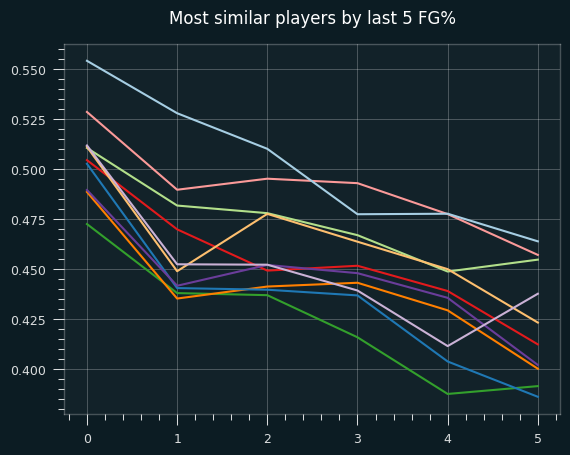

In [60]:
for idx, data in top_small_entropy.iterrows():
    plt.plot(number_cols, data[number_cols], label=data['player_name'])
plt.title("Most similar players by last 5 FG%")
#plt.xlim(0,8)
#_out  = plt.legend()

In [61]:
smallest_jensen = players_with_fives.sort_values("lbj_jensen")[1:101]

Wasserstein distance didn't seem to work right. both the normalized and non-normalized data gave meaningless results. probably a skill issue, tbh.

The Jensen-Shannon distance closely matches the relative entropy. They agree exactly on the first 30 or so most similar players. I guess that's unsurprising, since the Jensen-Shannon distance is based on relative entropy.

There are certainly other metrics I could use here. [https://arxiv.org/html/2408.07706v1](https://arxiv.org/html/2408.07706v1)

## Relative entropy vs. Jenson-Shannon distance

In [62]:
smallest_entropy.index == smallest_jensen.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True, False, False, False,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
       False, False, False, False,  True,  True, False, False, False,
       False])

In [63]:
sum(smallest_entropy.index == smallest_jensen.index)

np.int64(73)

they are basically identical by correlation with z-score.

In [71]:
players_with_fives.lbj_jensen.corr(players_with_fives.z_score, method='spearman')

np.float64(-0.28560366362201944)

In [72]:
players_with_fives.lbj_entropy.corr(players_with_fives.z_score, method='spearman')

np.float64(-0.28534415580664907)

looking at top 180 values, since that's the number of players my 4 out of 5 decreasing metric turned up.

In [73]:
players_with_fives.sort_values("lbj_jensen")[:180].z_score.describe()

count    180.000000
mean       1.155030
std        1.265793
min       -2.559990
25%        0.332964
50%        1.225259
75%        1.881895
max        5.897434
Name: z_score, dtype: float64

In [75]:
players_with_fives.sort_values("lbj_entropy")[:180].z_score.describe()

count    180.000000
mean       1.138156
std        1.289399
min       -2.559990
25%        0.288246
50%        1.225259
75%        1.881895
max        5.897434
Name: z_score, dtype: float64

since the goal is to find un-streaky players, the Jensen distance does a slightly better job than relative entropy.

In [76]:
players_with_fives


,player_name,makes,misses,total_streaks,raw_data,expected_streaks,variance,sd,z_score,ww_percentile,0,1,2,3,4,5,diffs,lbj_entropy,lbj_wass,lbj_jensen
player_id,,,,,,,,,,,,,,,,,,,,
15,Eric Piatkowski,228,340,293,WLLLWLWWLLLLWWWLLWWLWLLWLLLLWLWWLWLLLLWWWLLLWL...,273.957746,130.922352,11.442131,1.664223,95.196603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,Chris Whitney,17,28,20,WLLLLWLLLWWWLWWLWLLWLLWLLLWWLLLLWLLLLWWWWLLLL,22.155556,9.690954,3.113030,-0.692430,24.433363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,Gary Payton,1195,1467,1311,WWWWWWLLLWLLLWWLWLLLLWWWLLLWWLLWLWLLLLWLLLWLLL...,1318.103681,651.426157,25.523051,-0.278324,39.038177,0.446809,0.435897,0.44686,0.466307,0.417178,0.470588,-0.02378,0.002972,0.054745,0.02728
57,Doug Christie,461,602,561,LLLLWLWLWWWLWLLLWWWLLWLLWLWLWLWWLWLWWWWLWLLLWL...,523.148636,256.230743,16.007209,2.364645,99.097632,0.444444,0.434783,0.507692,0.439716,0.454545,0.166667,0.277778,0.047094,0.094043,0.102025
72,Kenny Anderson,198,259,224,WWWWLLWLLLWWWLLLWLLLLLLLLLLLWLLWLWWWWLWWLLLLWW...,225.428884,109.964682,10.486405,-0.136261,44.580763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641926,Dexter Dennis,10,9,11,LWWLWLWLWWWLWWWLLLL,10.473684,4.459834,2.111832,0.249222,59.840562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1641931,Onuralp Bitim,32,52,44,WWWLLLWLWLLLWWLWWLLLLWWWLWWLWLWWLLLWLWWLWLWWLW...,40.619048,18.434336,4.293523,0.787454,78.449199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1641970,Maozinha Pereira,18,17,21,WWLLWLLWLLWWWLLWWWLLWLWLWLWWLWLLLWW,18.485714,8.478367,2.911764,0.863492,80.606660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
